# <a id='toc1_'></a>[Прогнозирование оттока клиентов в сети отелей «Как в гостях»](#toc0_)

Цель:  построить такую систему бронирования для сети отелей, которая позволила бы, как можно раньше, определять "недобросовестных" клиентов, которые часто отказываются от бронирования номера и тем самым, приносят отелю убытки. 

подключаем библиотеки, загружаем данные с возможностью работы в локальном приложении

**Table of contents**<a id='toc0_'></a>    
- [Прогнозирование оттока клиентов в сети отелей «Как в гостях»](#toc1_)    
    - [Шаг 2. Предобработка и исследовательский анализ данных](#toc1_1_1_)    
    - [Шаг 3. Формулировка ML-задачи на основе бизнес-задачи](#toc1_1_2_)    
    - [Шаг 4. Разработка модели ML](#toc1_1_3_)    
    - [Шаг 5. Опишите портрет «ненадёжного» клиента](#toc1_1_4_)    
    - [Шаг 6. Напишите общий вывод](#toc1_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# импорты сторонних библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
try:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')
except:
    df_train = pd.read_csv('hotel_train.csv')
    df_test = pd.read_csv('hotel_test.csv')
    
#изначально обрежем значения до 3 знака после запятой при воспроизведении
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#для удобства отображения таблиц
pd.options.display.max_columns = 100

### <a id='toc1_1_1_'></a>[Шаг 2. Предобработка и исследовательский анализ данных](#toc0_)

**У нас имеется 2 набора данных: тренинговый и тестовый. На тренинговом мы проводим обучение модели, на тестовом - предсказание. Кроме того, тестовый набор данных мы будем использовать для обсучета прибыли сети гостиниц, т е для построения финансовой модели. Я исхожу из того, что данные в обоих выборках должны быть равнозначны => проведем предобработку данных в обоих наборах.**

выводим полученные данные каждого датасета на экран для контроля подключения и изучения

In [ ]:
df_train.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.000,2015,July,27,1,0,1,1.000,0.000,0.000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.000,2015,July,27,1,0,2,2.000,0.000,0.000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.000,2015,July,27,1,0,3,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [ ]:
df_test.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.000,2017,January,1,1,1,0,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.000,2017,January,1,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.000,2017,January,1,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.000,2017,January,1,1,2,2,1.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.000,2017,January,1,1,2,5,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


Изучим обе выборки на наличие пропусков

In [ ]:
 pd.DataFrame(round(df_train.isna().mean()*100,)).style.background_gradient('coolwarm').format("{:.2f}")

,0
id,0.00
is_canceled,0.00
lead_time,0.00
arrival_date_year,0.00
arrival_date_month,0.00
arrival_date_week_number,0.00
arrival_date_day_of_month,0.00
stays_in_weekend_nights,0.00
stays_in_week_nights,0.00
adults,0.00


In [ ]:
pd.DataFrame(round(df_test.isna().mean()*100,)).style.background_gradient('coolwarm').format("{:.2f}")

,0
id,0.00
is_canceled,0.00
lead_time,0.00
arrival_date_year,0.00
arrival_date_month,0.00
arrival_date_week_number,0.00
arrival_date_day_of_month,0.00
stays_in_weekend_nights,0.00
stays_in_week_nights,0.00
adults,0.00


видим, что пропусков нет

изучим общую информацию о датасете и оценим соответствие типов данных признакам

In [ ]:
print ('Проверим датафрейм на дубликаты в обоих датасетах')
print (df_train.duplicated().sum())
print (df_test.duplicated().sum())

Проверим датафрейм на дубликаты в обоих датасетах
0
0


In [ ]:
df_without_id_train = df_train.drop(columns = ['id'], axis = 1)
df_without_id_test = df_test.drop(columns = ['id'], axis = 1)

In [ ]:
print (df_without_id_train.duplicated(keep= 'last').value_counts())
print (df_without_id_test.duplicated(keep= 'last').value_counts())

False    43852
True     21377
dtype: int64
False    24695
True      7717
dtype: int64


После даления id  в нашем распоряжении осталось большое ко-во полных дубликатов, в которых совпадают абсолютно все признаки. Это означает, что отличия были только в номере записи. Как вариант причина в том, что мы имеем повторяющиеся заказы. Кол-во дубликатов очень большое. Пока принимаю решение ничего с ними не делать, т к потеряется огромный раздел датасетов. 

при анализе типов данных, выявлено 7 столбцов с несоответствиями признака типу данных. Приведем их в соответствие.

In [ ]:
#Округляем вещественные числа тренинговой выборки, для последующей конвертации в целые числа
columns_to_int = ['lead_time', 'adults', 'children', 'babies']
for column in columns_to_int:
    df_train[column] = np.floor(df_train[column])

In [ ]:
#делаем тоже самое для тестовой выборки
columns_to_int = ['lead_time', 'adults', 'children', 'babies']
for column in columns_to_int:
    df_test[column] = np.floor(df_test[column])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

***изучаем распределение заезда в выборках по годам:*** оценим колонку 'arrival_date_year' в обоих датасетах

In [ ]:
df_train['arrival_date_year'].value_counts()

2016    46901
2015    18328
Name: arrival_date_year, dtype: int64

In [ ]:
df_test['arrival_date_year'].value_counts()

2017    32412
Name: arrival_date_year, dtype: int64

мы видим, что данные по годам в обоих датасетах различаются: в тренинговом даны данные за 2015-2016 гг, в тестовом за 2017 год. В целом, вполне логично обучить модель на данных предыдущих годов и предсказать на данных будущего года. Далее, приведем данные к нужному типу, автоматизируя операцию в цикле.

все в порядке: типы данных приведены в соответствие.

 МОЖНО ИДТИ ДАЛЬШЕ. Применим описательную статистику для описания датасета. - **Информация предоставленная методом .describe() поможет нам выбрать нужный спсоб заполнения пропущенных значений, при наличии пропусков** Намного интереснее будет ниже обзорно взглянуть на данные через гистограммы - понять какие именно колонки целесообразно изучить подробнее - проработать эти колонки через графики boxplot и уже для них прицельно изучить описательную статистику. 

In [ ]:
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000
mean,43544.069,0.369,96.338,2015.719,31.340,15.848,0.825,2.225,1.837,0.075,0.007,0.027,0.129,0.108,0.194,3.334,0.057,0.513,3.050
std,25614.859,0.482,96.128,0.449,13.464,8.748,0.853,1.355,0.480,0.334,0.099,0.163,0.965,1.327,0.594,18.240,0.232,0.753,1.738
min,0.000,0.000,0.000,2015.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,19108.000,0.000,17.000,2015.000,21.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,40554.000,0.000,64.000,2016.000,34.000,16.000,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
75%,67414.000,1.000,151.000,2016.000,42.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000
max,84121.000,1.000,374.000,2016.000,53.000,31.000,4.000,6.000,4.000,3.000,10.000,1.000,26.000,58.000,17.000,259.000,3.000,5.000,10.000


построим гистограмму, позволяющую нам получить общее представление о данных для каждого датасета. Это надо нам для того, чтобы понимать с какими колонками данных нам необходимо ознакомиться более предметно

<function matplotlib.pyplot.show(close=None, block=None)>

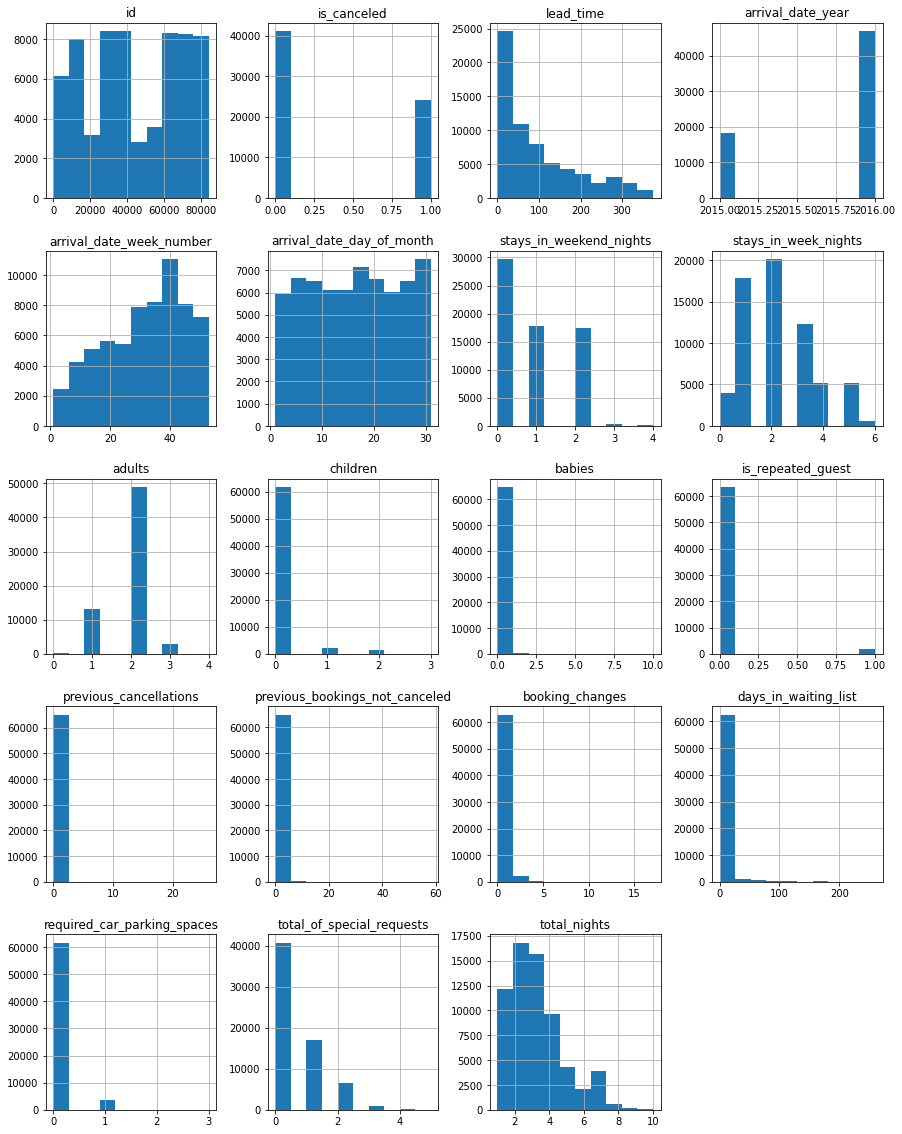

In [ ]:
df_train.hist(figsize=(15, 20))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

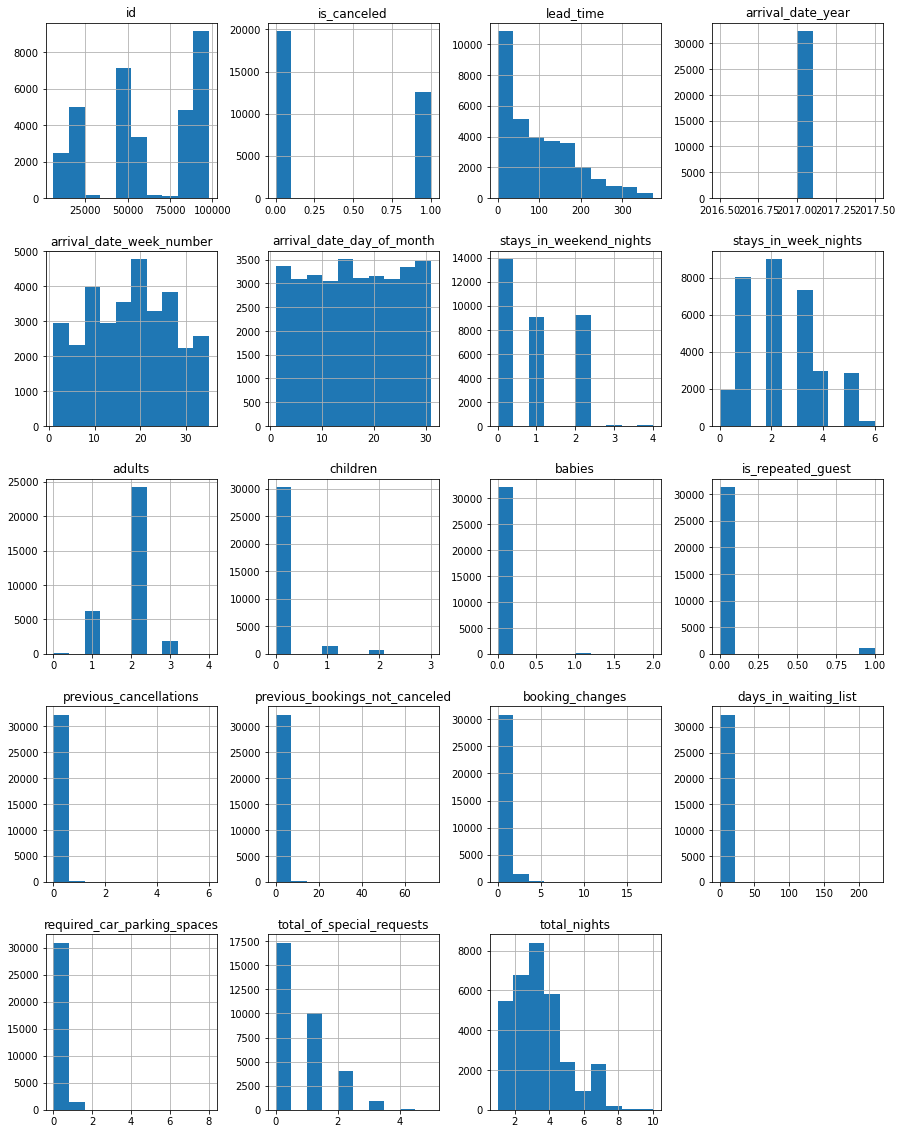

In [ ]:
df_test.hist(figsize=(15, 20))
plt.show

после проведенного анализа информации на общей гистограмме, приходим к выводу, что имеет смысл изучить колонки, кроме id и имеющие более 1 значения, для понимания распределния признака внутри колонки.

***изучаем распределение количества дней между датой бронирования и датой прибытия***

count   65229.000
mean       96.338
std        96.128
min         0.000
25%        17.000
50%        64.000
75%       151.000
max       374.000
Name: lead_time, dtype: float64

median  64.0


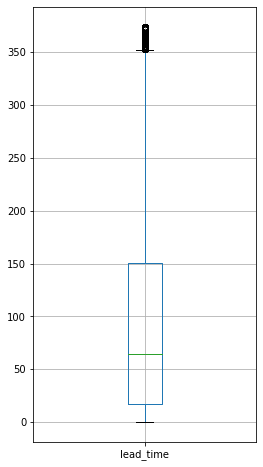

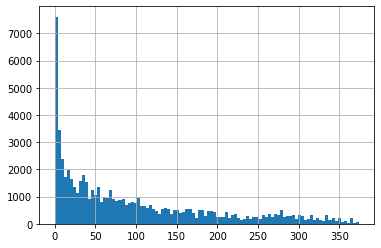

In [ ]:
def basis_stat_f(target_column):
    display(df_train[target_column].describe())
    print('median ', df_train[target_column].median())
    df_train.boxplot(column = target_column, figsize = (4,8))
    plt.show()
    df_train[target_column].hist(bins = 100)
    
basis_stat_f('lead_time')


мы видим, что среднее время м/у датой бронирования/прибытия - квартал. 

In [ ]:
df_global = pd.concat([df_train, df_test], ignore_index=True)
df_global.shape

(97641, 25)

count   61006.000
mean       75.123
std        81.381
min         0.000
25%         9.000
50%        45.000
75%       118.000
max       373.000
Name: lead_time, dtype: float64

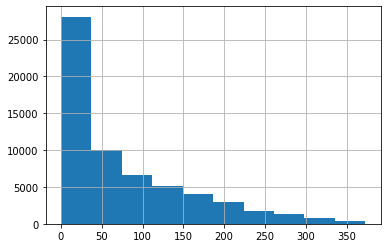

In [ ]:
df_global = df_global.loc[df_global['is_canceled'] == 0]
df_global['lead_time'].hist()
df_global['lead_time'].describe()

count   24044.000
mean      137.621
std       105.404
min         0.000
25%        45.000
50%       107.500
75%       221.000
max       374.000
Name: lead_time, dtype: float64

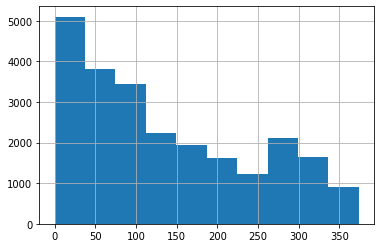

In [ ]:
df_train_1 = df_train.loc[df_train['is_canceled'] == 1]
df_train_1['lead_time'].hist()
df_train_1['lead_time'].describe()

count   41185.000
mean       72.237
std        81.077
min         0.000
25%         8.000
50%        41.000
75%       110.000
max       373.000
Name: lead_time, dtype: float64

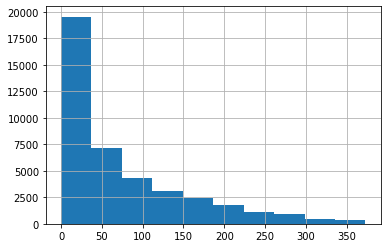

In [ ]:
df_train_1 = df_train.loc[df_train['is_canceled'] == 0]
df_train_1['lead_time'].hist()
df_train_1['lead_time'].describe()

count   12591.000
mean      123.511
std        87.531
min         0.000
25%        52.000
50%       111.000
75%       177.000
max       373.000
Name: lead_time, dtype: float64

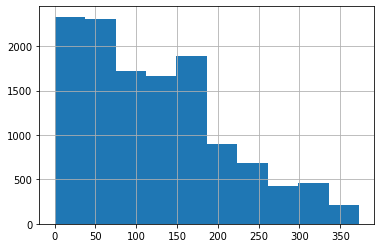

In [ ]:
df_test_1 = df_test.loc[df_test['is_canceled'] == 1]
df_test_1['lead_time'].hist()
df_test_1['lead_time'].describe()

count   19821.000
mean       81.120
std        81.686
min         0.000
25%        11.000
50%        53.000
75%       133.000
max       368.000
Name: lead_time, dtype: float64

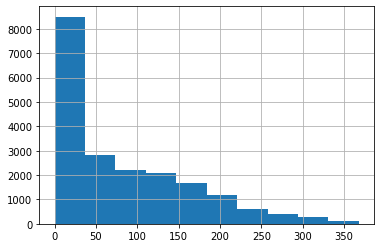

In [ ]:
df_test_1 = df_test.loc[df_test['is_canceled'] == 0]
df_test_1['lead_time'].hist()
df_test_1['lead_time'].describe()

количество дней между датой бронирования и датой прибытия имеет взаимосвязь с признаком отмены бронирования - описательная статистика сильно отличается

In [ ]:
df_train['arrival_date_year'].value_counts()

2016    46901
2015    18328
Name: arrival_date_year, dtype: int64

In [ ]:
df_test['arrival_date_year'].value_counts()

2017    32412
Name: arrival_date_year, dtype: int64

по данным диаграммы, нецелесообразно собирать подробную статистику по годам заезда: нам достаточно понимать за какие года имеет место быть собрана статистика.

***изучаем неделю заезда***

count   65229.000
mean       31.340
std        13.464
min         1.000
25%        21.000
50%        34.000
75%        42.000
max        53.000
Name: arrival_date_week_number, dtype: float64

median  34.0


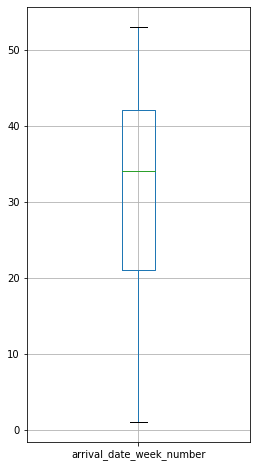

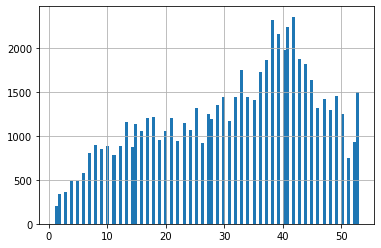

In [ ]:
basis_stat_f('arrival_date_week_number')

In [ ]:
df_train['arrival_date_week_number'].median()

34.0

In [ ]:
df_test['arrival_date_week_number'].median()

18.0

из интересного в тренинговой выборке максимум заездов крутится вокруг 40 недели, в тестовой - вокруг 18 

***изучаем месяц заезда*** данный параметр понадобится нам для расчета прибыли

мы видим, что пик заезда в течении года приходится на недели, начиная с 34 по 43, т е на осень. Возможно, эта информация будет иметь значение для нас.

count   65229.000
mean       15.848
std         8.748
min         1.000
25%         8.000
50%        16.000
75%        23.000
max        31.000
Name: arrival_date_day_of_month, dtype: float64

median  16.0


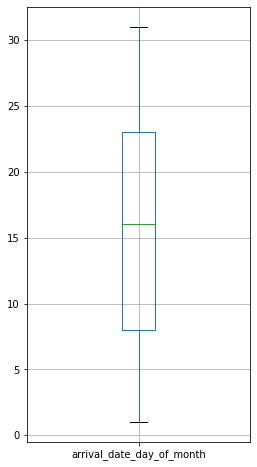

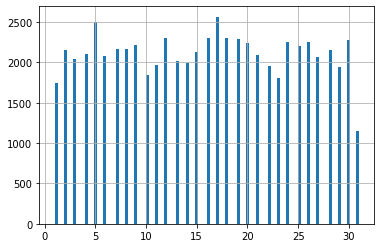

In [ ]:
basis_stat_f('arrival_date_day_of_month')

по дням заезда особых закономерностей нет: на общей гистограмме казалось, что больший заезд в конце месяца. Но стаститика и приближенная гистограмма показывают, что заезд равномерно распределн в течении месяца.

***изучаем кол-во ночей в выходные***

In [ ]:
df_train['stays_in_weekend_nights'].value_counts()


0    29738
1    17721
2    17357
3      261
4      152
Name: stays_in_weekend_nights, dtype: int64

In [ ]:
df_train['stays_in_weekend_nights'].median()

1.0

In [ ]:
df_test['stays_in_weekend_nights'].value_counts()

0    13915
2     9221
1     9105
3      101
4       70
Name: stays_in_weekend_nights, dtype: int64

In [ ]:
df_test['stays_in_weekend_nights'].median()

1.0

кол-во ночей в выходные дни нам достаточно визуализировать с помощью метода .value_counts(): в общей таблице статистики среднее кол-во ночей 0.85, медиана признака - 1 ночь. Видимо в выходные люди решают поразвлечься ))

***изучаем кол-во ночей на неделе***

count   65229.000
mean        2.225
std         1.355
min         0.000
25%         1.000
50%         2.000
75%         3.000
max         6.000
Name: stays_in_week_nights, dtype: float64

median  2.0


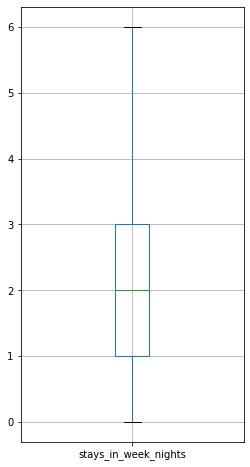

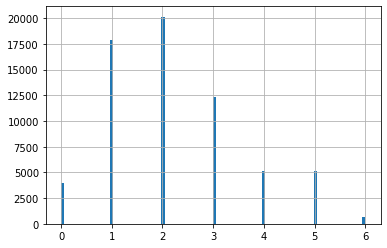

In [ ]:
basis_stat_f('stays_in_week_nights')

вторник и среда - самые нагруженные рабочие дни в гостиницах

***изучаем кол-во взрослых постояльцев***

count   65229.000
mean        1.837
std         0.480
min         0.000
25%         2.000
50%         2.000
75%         2.000
max         4.000
Name: adults, dtype: float64

median  2.0


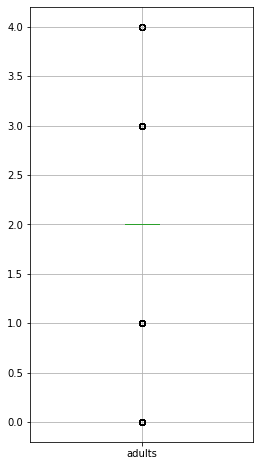

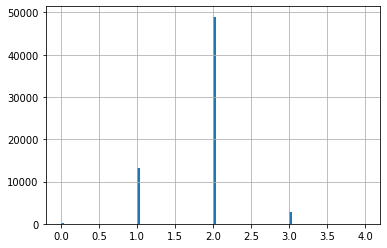

In [ ]:
basis_stat_f('adults')

чаще всего останавливаются взрослые вдвоем

In [ ]:
print(df_train['adults'].unique())
print(df_test['adults'].unique())

[1. 2. 3. 4. 0.]
[2. 1. 3. 4. 0.]


In [ ]:
print(df_train['adults'].value_counts())
print(df_test['adults'].value_counts())

2.000    48980
1.000    13212
3.000     2858
0.000      166
4.000       13
Name: adults, dtype: int64
2.000    24237
1.000     6280
3.000     1817
0.000       69
4.000        9
Name: adults, dtype: int64


Не понятно, что такое “0” взрослых. Удаляем.

In [ ]:
df_train = df_train.query('adults!=0')
df_test = df_test.query('adults!=0')


In [ ]:
print(df_train['adults'].value_counts())
print(df_test['adults'].value_counts())

2.000    48980
1.000    13212
3.000     2858
4.000       13
Name: adults, dtype: int64
2.000    24237
1.000     6280
3.000     1817
4.000        9
Name: adults, dtype: int64


***изучаем кол-во детей и их прогностическую ценность***

count   65063.000
mean        0.070
std         0.321
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         3.000
Name: children, dtype: float64

median  0.0


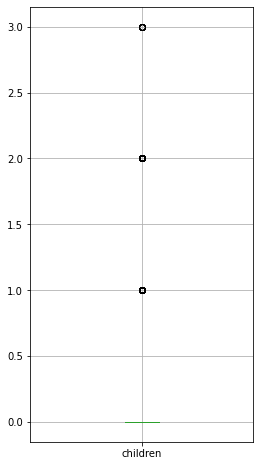

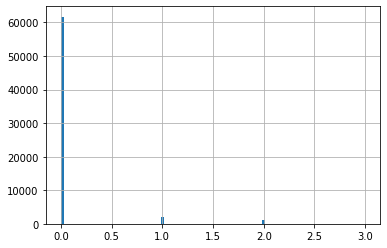

In [ ]:
basis_stat_f('children')

In [ ]:
df_train['children'].median()

0.0

In [ ]:
print(df_train['children'].unique())
print(df_test['children'].unique())

[0. 1. 2. 3.]
[0. 2. 1. 3.]


In [ ]:
print (df_train['children'].value_counts())
print (df_test['children'].value_counts())

0.000    61697
1.000     2163
2.000     1195
3.000        8
Name: children, dtype: int64
0.000    30353
1.000     1392
2.000      595
3.000        3
Name: children, dtype: int64


все в порядке: чаще всего заселяются без детей или с 1 ребенком.

и чаще всего, без детей

count   41067.000
mean        0.075
std         0.326
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         3.000
Name: children, dtype: float64

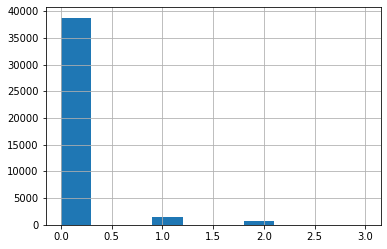

In [ ]:
df_train_2 = df_train.loc[df_train['is_canceled'] == 0]
df_train_2['children'].hist()
df_train_2['children'].describe()

count   23996.000
mean        0.063
std         0.311
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         3.000
Name: children, dtype: float64

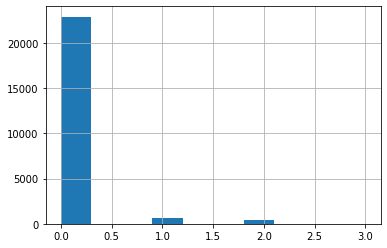

In [ ]:
df_train_1 = df_train.loc[df_train['is_canceled'] == 1]
df_train_1['children'].hist()
df_train_1['children'].describe()

count   19821.000
mean        0.080
std         0.332
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         3.000
Name: children, dtype: float64

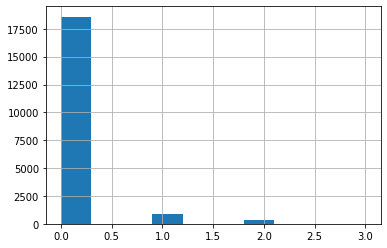

In [ ]:
df_test_1 = df_test_1.loc[df_test_1['is_canceled'] == 0]
df_test_1['children'].hist()
df_test_1['children'].describe()

count   12560.000
mean        0.085
std         0.349
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         3.000
Name: children, dtype: float64

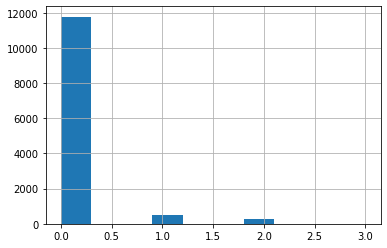

In [ ]:
df_test_2 = df_test.loc[df_test['is_canceled'] == 1]
df_test_2['children'].hist()
df_test_2['children'].describe()

Мы изучили влияние количества детей в бронировании  на факт отмены бронирования. Заметной разницы по описательной статитсике не нашли.

***изучаем кол-во младенцев и их прогностическую ценность***

In [ ]:
print (df_train['babies'].unique())
print (df_test['babies'].unique())

[ 0.  1.  2. 10.  9.]
[0. 1. 2.]


In [ ]:
print (df_train['babies'].value_counts())
print (df_test['babies'].value_counts())

0.000     64614
1.000       444
2.000         3
9.000         1
10.000        1
Name: babies, dtype: int64
0.000    32168
1.000      171
2.000        4
Name: babies, dtype: int64


что такое кол-во младенцев 9-10, да и более 1 тоже едва ли ( 2 младенца -  всего 4 случая - слишком мало для прогноза): некорректные данные. Удаляем и сразу проверяем.

In [ ]:
df_train = df_train.loc[df_train['babies']<1]

In [ ]:
print (df_train['babies'].value_counts())
print (df_test['babies'].value_counts())

0.000    64614
Name: babies, dtype: int64
0.000    32168
1.000      171
2.000        4
Name: babies, dtype: int64


все в порядке

***Проверяем количество изменений параметров заказа***

count   64614.000
mean        0.189
std         0.588
min         0.000
25%         0.000
50%         0.000
75%         0.000
max        17.000
Name: booking_changes, dtype: float64

median  0.0


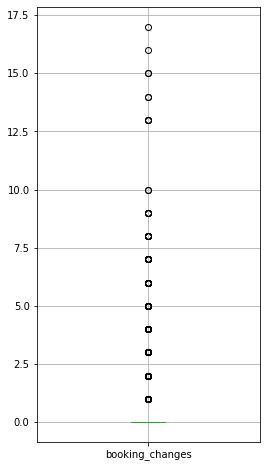

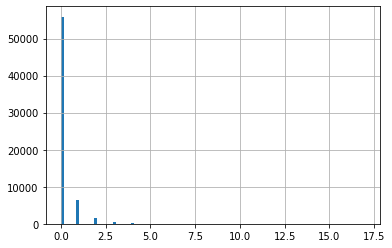

In [ ]:
basis_stat_f('booking_changes')

количество изменений параметров заказа в целом, дело не частое. Отсюда следует вывод: имеет смысл сразу отследить людей, которые изменяют параметры заказа и сопоставить их на предмет отказов от бронирования. Посмотрим сразу на этих людей и оценим их общее кол-во в датасете.

In [ ]:
df_train['booking_changes'].value_counts()

0     55897
1      6385
2      1695
3       394
4       143
5        40
6        19
7        17
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [ ]:
# исправляем
df_train.drop(df_train[df_train['booking_changes'] > 8].index, inplace=True)
df_test.drop(df_test[df_test['booking_changes'] > 8].index, inplace=True)

In [ ]:
print(df_train['booking_changes'].value_counts())
print(df_train['booking_changes'].value_counts())

0    55897
1     6385
2     1695
3      394
4      143
5       40
6       19
7       17
8        7
Name: booking_changes, dtype: int64
0    55897
1     6385
2     1695
3      394
4      143
5       40
6       19
7       17
8        7
Name: booking_changes, dtype: int64


один-два раза изменить параметры заказа - обычное дело: жизненные обстоятельства никто не отменял... Но вот 3-17 - это явно предмет для исследования. Люди из этого списка вполне могут попасть в "черный список"..

могло ли кол-во дней ожидания подтверждения бронирования побудить клиентов отказаться от заказа? Вполне возможно.

***Проверим country - гражданство постояльца***

In [ ]:
print (df_train['country'].unique())
print ('')
print (df_test['country'].unique())

['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE']

['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' '

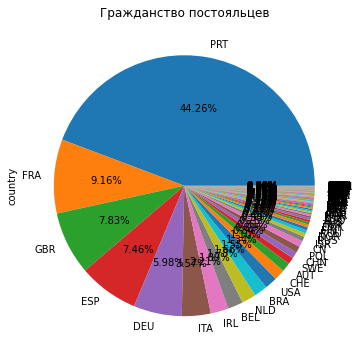

In [ ]:
df_train['country'].value_counts().plot.pie(legend=False, autopct='%1.2f%%', figsize=(12,6))
plt.title('Гражданство постояльцев')
plt.show()

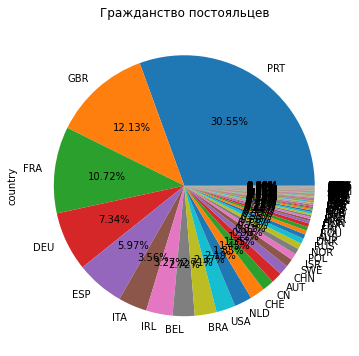

In [ ]:
df_test['country'].value_counts().plot.pie(legend=False, autopct='%1.2f%%', figsize=(12,6))
plt.title('Гражданство постояльцев')
plt.show()

лидируют Португальцы. В остальном все нормально

***изучим сколько дней заказ ожидал подтверждения***

count   64597.000
mean        3.367
std        18.326
min         0.000
25%         0.000
50%         0.000
75%         0.000
max       259.000
Name: days_in_waiting_list, dtype: float64

median  0.0


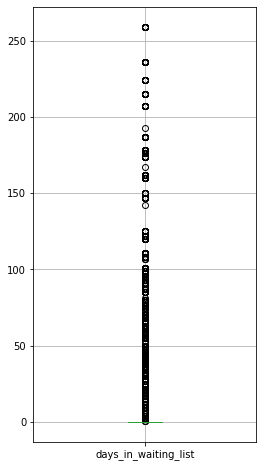

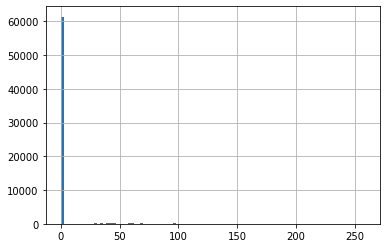

In [ ]:
basis_stat_f('days_in_waiting_list')

учитывая широкий разброс признака, дополнительно исследуем медиану.

In [ ]:
df_train['days_in_waiting_list'].median()

0.0

In [ ]:
df_train['days_in_waiting_list'].value_counts()

0      61373
39       185
58       164
44       137
31       126
       ...  
89         1
76         1
13         1
142        1
14         1
Name: days_in_waiting_list, Length: 97, dtype: int64

удвительное рядом: были заказы, в которых клиент ожидал подтверждения в течении 185 дней - очевидно, эти клиенты не оценили клиент-ориентированность отеля... С заказами, ожидающими подтверждения более одного дня явно надо что - то делать на административном уровне. Исследуем эти брони и оценим их количество.

In [ ]:
df_train[df_train['days_in_waiting_list'] > 1]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1352,1366,0,59.000,2015,October,41,8,0,3,2.000,0.000,0.000,BB,PRT,Corporate,0,0,0,A,0,50,Contract,0,0,3
1509,1523,0,47.000,2015,October,43,19,1,4,2.000,0.000,0.000,HB,ESP,Direct,0,0,0,A,0,47,Transient-Party,0,0,5
1511,1525,0,47.000,2015,October,43,19,1,4,2.000,0.000,0.000,HB,ESP,Direct,0,0,0,A,0,47,Transient-Party,0,0,5
1512,1526,0,47.000,2015,October,43,19,1,4,2.000,0.000,0.000,HB,ESP,Direct,0,0,0,A,0,47,Transient-Party,0,0,5
1513,1527,0,47.000,2015,October,43,19,1,4,2.000,0.000,0.000,HB,ESP,Direct,0,0,0,A,0,47,Transient-Party,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63825,82536,0,45.000,2016,November,49,28,1,1,2.000,0.000,0.000,BB,ITA,Direct,0,0,0,D,0,10,Transient-Party,0,0,2
64020,82735,0,38.000,2016,December,49,2,0,2,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,9,Transient-Party,0,0,2
64839,83566,0,208.000,2016,December,53,27,0,1,2.000,0.000,0.000,BB,BRA,TA/TO,0,0,0,A,2,167,Transient-Party,0,1,1
65190,83967,0,304.000,2016,December,53,29,2,3,1.000,0.000,0.000,BB,SWE,TA/TO,0,0,0,A,1,35,Transient-Party,0,1,5


3221 бронь, ожидающая подтверждения более 1 дня !!! Это очень много. **Интересно исследовать такой факт: если бронь подтверждается более 1 дня и клиент отменил заказ.**

In [ ]:
df_train[(df_train['days_in_waiting_list'] > 1) & (df_train['booking_changes']>0)& (df_train['is_canceled']== True)].count()

id                                28
is_canceled                       28
lead_time                         28
arrival_date_year                 28
arrival_date_month                28
arrival_date_week_number          28
arrival_date_day_of_month         28
stays_in_weekend_nights           28
stays_in_week_nights              28
adults                            28
children                          28
babies                            28
meal                              28
country                           28
distribution_channel              28
is_repeated_guest                 28
previous_cancellations            28
previous_bookings_not_canceled    28
reserved_room_type                28
booking_changes                   28
days_in_waiting_list              28
customer_type                     28
required_car_parking_spaces       28
total_of_special_requests         28
total_nights                      28
dtype: int64

 итак, у нас 28 клиентов отменили бронь после того, как она подтверждалась более 1 дня! О чем это говорит? **Эти люди ушли к конкурентам.** В то же время, у нас еще 304 клиента, которые не отменили бронь, но внесли изменения в бронь после того, как не получили подтверждение в течении суток. **Это явно административная проблема, которую необходимо  решать.** Ничего удалять не буду, т к данный признак способен напрямую влиять на целевой признак.

***Проверим distribution_channel - канал дистрибуции заказа***

In [ ]:
print(df_train['distribution_channel'].value_counts())
print(df_test['distribution_channel'].value_counts())

TA/TO        53973
Direct        6709
Corporate     3816
GDS             99
Name: distribution_channel, dtype: int64
TA/TO        27017
Direct        3634
Corporate     1601
GDS             85
Name: distribution_channel, dtype: int64


все в порядке, ничего делать не будем

count     23911
unique        4
top       TA/TO
freq      21890
Name: distribution_channel, dtype: object

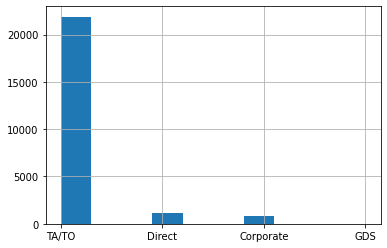

In [ ]:
df_train_3 = df_train.loc[df_train['is_canceled'] == 1]
df_train_3['distribution_channel'].hist()
df_train_3['distribution_channel'].describe()

count     40686
unique        4
top       TA/TO
freq      32083
Name: distribution_channel, dtype: object

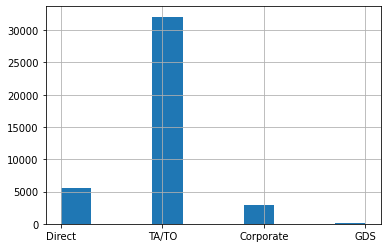

In [ ]:
df_train_3 = df_train.loc[df_train['is_canceled'] == 0]
df_train_3['distribution_channel'].hist()
df_train_3['distribution_channel'].describe()

count     19777
unique        4
top       TA/TO
freq      15503
Name: distribution_channel, dtype: object

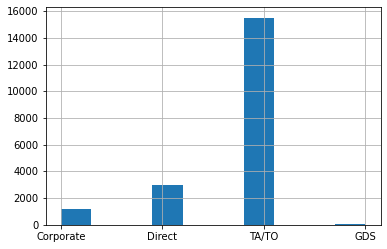

In [ ]:
df_test_3 = df_test.loc[df_test['is_canceled'] == 0]
df_test_3['distribution_channel'].hist()
df_test_3['distribution_channel'].describe()

count     12560
unique        4
top       TA/TO
freq      11514
Name: distribution_channel, dtype: object

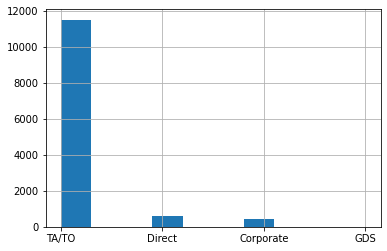

In [ ]:
df_test_3 = df_test.loc[df_test['is_canceled'] == 1]
df_test_3['distribution_channel'].hist()
df_test_3['distribution_channel'].describe()

Таким образом, мы видим влияние канала дистрибуции на факт отмены: вероятно дистриббютор TA/TO  - основной дистрибьютор сети отелей

***проверяем общее кол-во ночей***

count   64597.000
mean        3.044
std         1.735
min         1.000
25%         2.000
50%         3.000
75%         4.000
max        10.000
Name: total_nights, dtype: float64

median  3.0


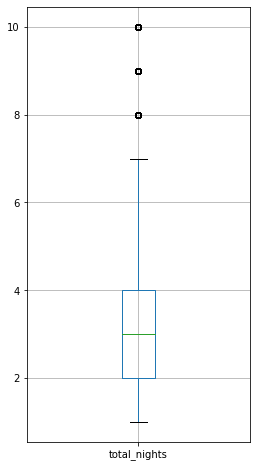

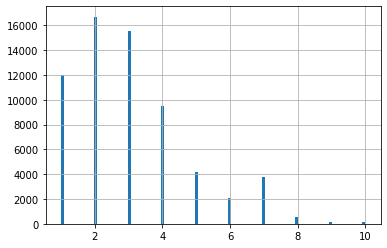

In [ ]:
basis_stat_f('total_nights')

в среднем, клиенты бронировали отель на 3 ночи, максимум на 10 ночей. Имеет смысл заложить эти показатели в бизнес модель.

In [ ]:
print(df_train['total_nights'].value_counts())
print(df_test['total_nights'].value_counts())

2     16704
3     15518
1     12013
4      9517
5      4216
7      3788
6      2043
8       532
9       148
10      118
Name: total_nights, dtype: int64
3     8376
2     6756
4     5803
1     5456
5     2403
7     2279
6      935
8      212
9       62
10      55
Name: total_nights, dtype: int64


все в порядке

***Проверим reserved_room_type - тип забронированной комнаты***

In [ ]:
print(df_train['reserved_room_type'].value_counts())
print(df_test['reserved_room_type'].value_counts())

A                   50206
D                    9297
E                    2405
F                    1190
B                     709
G                     577
C                     213
Name: reserved_room_type, dtype: int64
A                   23454
D                    6122
E                    1643
F                     503
G                     278
C                     201
B                     136
Name: reserved_room_type, dtype: int64


In [ ]:
print(df_train['reserved_room_type'].unique())
print(df_test['reserved_room_type'].unique())

['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']


некорректное написание - исправляем

In [ ]:
# исправляем
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()

In [ ]:
print(df_train['reserved_room_type'].unique())
print(df_test['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['A' 'E' 'G' 'D' 'F' 'C' 'B']


***Проверим total_of_special_requests — количество специальных отметок***

In [ ]:
print (df_train['total_of_special_requests'].unique())
print (df_test['total_of_special_requests'].unique())

[0 1 3 2 4 5]
[0 1 2 3 4 5]


In [ ]:
print (df_train['total_of_special_requests'].value_counts())
print (df_test['total_of_special_requests'].value_counts())

0    40547
1    16722
2     6249
3      966
4      101
5       12
Name: total_of_special_requests, dtype: int64
0    17318
1    10011
2     3967
3      899
4      124
5       18
Name: total_of_special_requests, dtype: int64


все в порядке

***Проверим такое бронирование при котором заселились только дети без взрослых***

In [ ]:
print (df_train.query('(children > 0 | babies > 0) & adults == 0').shape[0])
print (df_test.query('(children > 0 | babies > 0) & adults == 0').shape[0])

0
0


***Проверим заселения номера без постояльцев***

In [ ]:
print (df_train.query('adults == 0').shape[0])
print (df_test.query('adults == 0').shape[0])

0
0


***Отказ от брони или отмена заказа "is_canceled" наш целевой признак. Изучим его более подробно.***

In [ ]:
# какие значения имеем
print(df_train['is_canceled'].unique())
print (df_test['is_canceled'].unique())

[0 1]
[1 0]


In [ ]:
# что с балансом?
print(df_train['is_canceled'].value_counts())
print(df_test['is_canceled'].value_counts())

0    40686
1    23911
Name: is_canceled, dtype: int64
0    19777
1    12560
Name: is_canceled, dtype: int64


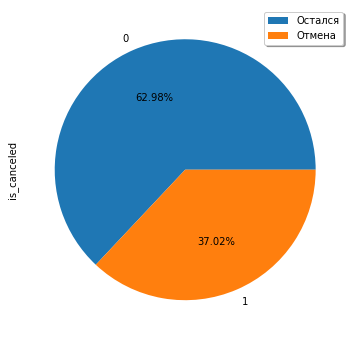

In [ ]:
df_train['is_canceled'].value_counts().plot.pie(legend=True, autopct='%1.2f%%', figsize=(12,6))
plt.legend(['Остался', 'Отмена'], shadow=True)
plt.show()

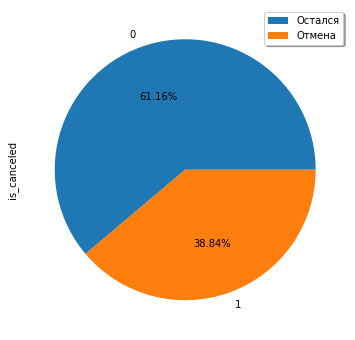

In [ ]:
df_test['is_canceled'].value_counts().plot.pie(legend=True, autopct='%1.2f%%', figsize=(12,6))
plt.legend(['Остался', 'Отмена'], shadow=True)
plt.show()

Не большой дисбаланс целевого признака есть, хотя он не является критичным. В моделях необходимо применить гиперпараметр class_weight='balanced' (Увеличиваем вес объектов редкого класса "1").

Убраем колонки которые нам не нужны для обучения. Колонка id не несёт иформацинной нагрузки, параметр arrival_date_week_number также не является информативным, более того, он отчасти дублирует другие временные параметры имеющиеся в нашем распоряжении, например arrival_date_day_of_month. Параметр country по-сути влияет на параметр lead_time тк удалённость страны может влиять на продолжительность времени между бронированием и прибитием в отель.

а теперь изучим корреляцию признаков через хетмэп

In [ ]:
df_train.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.000,2015,July,27,1,0,1,1.000,0.000,0.000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.000,2015,July,27,1,0,2,2.000,0.000,0.000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.000,2015,July,27,1,0,3,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [ ]:
df_train_nb = df_train.drop(columns = ['id', 'is_canceled', 'is_repeated_guest', 'required_car_parking_spaces'])

<AxesSubplot:>

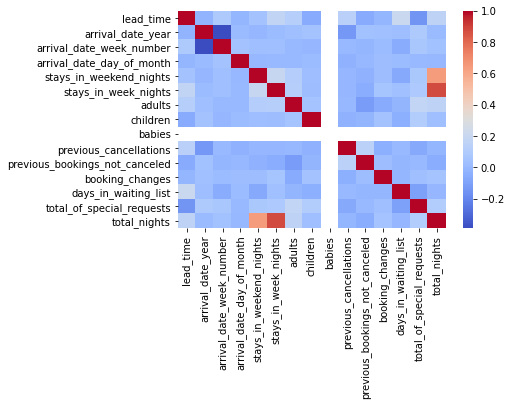

In [ ]:
sns.heatmap(df_train_nb.corr(), cmap= 'coolwarm')

<AxesSubplot:>

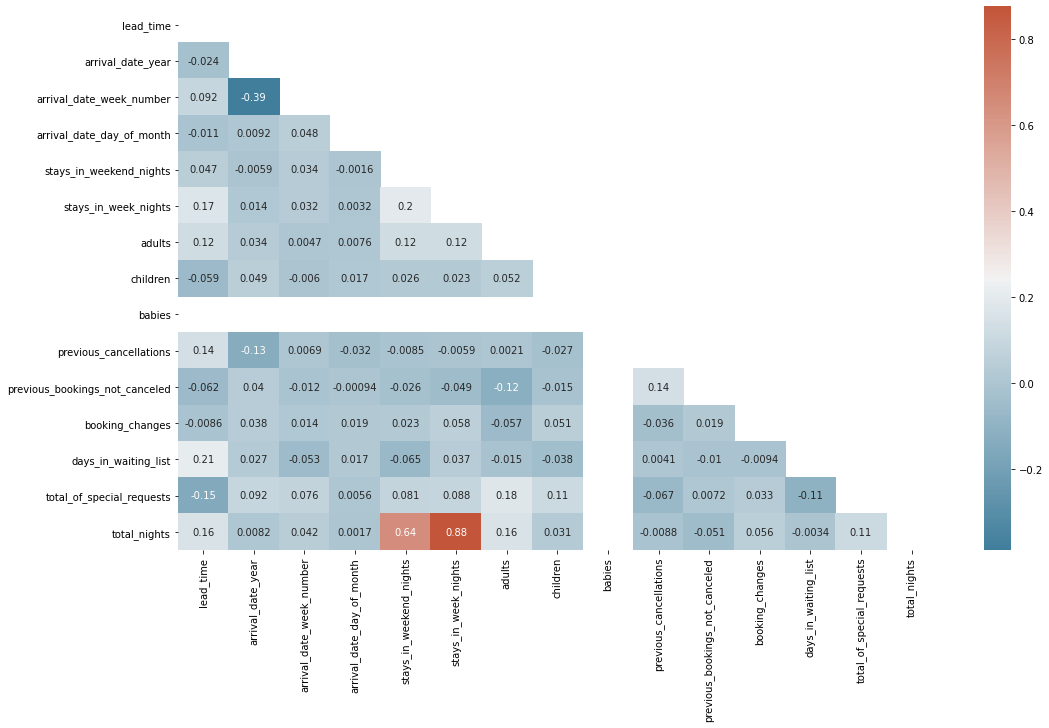

In [ ]:
# корреляция между разными значениями
corr = df_train_nb.corr()

# установка matplotlib plot конфигурации
f, ax = plt.subplots(figsize=(17, 10))

# задаём схему графика
mask = np.triu(np.ones_like(corr, dtype=bool))

# устанавливаем цвет
cmap = sns.diverging_palette(230, 20, as_cmap=True)


# выводим график
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)


С помощью данной методики нам удалось увидеть высокий уровень корреляции между колонками total_nights и stays_in_week_nights, stays_in_weekend_nights, что вполне логично, т к эти колонки описывают по-сути, одни и те же данные - количество ночей. previous_bookings_not_canceled и is_repeated_guest т е речь идет о постоянных клиентах - они бронируют номера и есть признак, что делают это более одного раза => эта группа клиентов менее подвержена отказу от брони. Довольно высокая корреляция между is_canceled и lead_time - чем раньше забронировал номер, тем выше вероятность отказа от номера - все логично, т к жизненные обстоятельства меняются.Корреляция между is_canceled и previous_cancellations говорит нам о том, что заказы чаще отменяются у людей, которые до этого отменяли заказы. Корреляция между is_canceled и days_in_waiting_list также подтверждает ситуацию с тем, что если заказ не подтвержден в течении суток (выяснили выше), высока вероятность отмены. Также обращает на себя внимание взаимосвязь между, ранним бронированием (lead_time) и поздним подтверждением (days_in_waiting_list) тем дольше заказ ожидает подтверждения - это и есть те люди, которые не получив подтверждения быстро, ушли к конкурентам! Менеджменту стоит призадуматься относительно цепочки создания ценности в сети гостиниц. Корреляция между  stays_in_week_nights и adults говорит нам о том, что на выходные гостиницу бронируют преимущественно взрослые люди )).

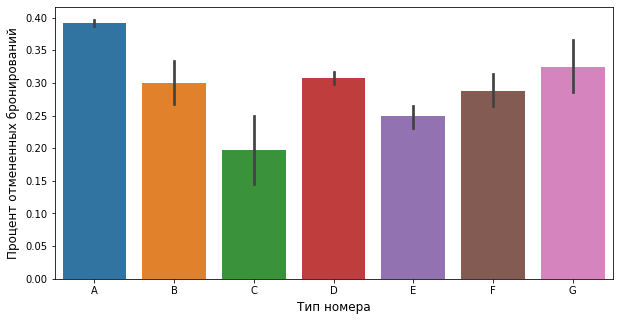

In [ ]:
plt.figure(figsize=(10,5)) 
sns.barplot(data = df_train, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
plt.xlabel("Тип номера", fontsize = 12, labelpad = 5)
plt.ylabel("Процент отмененных бронирований", fontsize = 12, labelpad = 5);
plt.show()

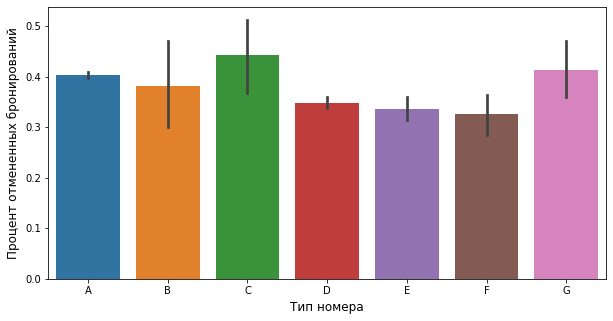

In [ ]:
plt.figure(figsize=(10,5)) 
sns.barplot(data = df_test, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
plt.xlabel("Тип номера", fontsize = 12, labelpad = 5)
plt.ylabel("Процент отмененных бронирований", fontsize = 12, labelpad = 5);
plt.show()

ВЫВОДЫ: В каждой выборке баланс бронирований смещен к определенной категории номеров. Однозначных выводом сделать не могу.

на основании проведенного исследовательского анализа данных, выявлен целевой признак для постановки задачи ML - is_canceled. Также пока удалим некоторые признаки - день и год заезда.

In [ ]:
df_train = df_train.drop(columns = ['id', 'arrival_date_year',  'arrival_date_day_of_month'], axis=1)
#df_train = reset_index(drop=True, axis = 1)


In [ ]:
df_train.shape

(64597, 22)

In [ ]:
df_test = df_test.drop(columns = ['id', 'arrival_date_year',  'arrival_date_day_of_month'], axis=1)

In [ ]:
df_test.shape

(32337, 22)

итак, мы получили равнозначные датасеты. Переходим к написанию функции подсчета прибыли.

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 2:</b></u></p>
    <p>В данном раздели я провел предобработку (убрал выбросы, неявные дубликаты, лишние пропуски) и исследовательский анализ данных. Так же в конце я провел анализ значений "отмена заказа" (is_canceled) так, как в дальнейшем он будет целевым признаком. Переходим к написанию функции подсчета прибыли.</p>
</div>

### <a id='toc1_1_2_'></a>[Шаг 3. Формулировка ML-задачи на основе бизнес-задачи](#toc0_)

***Оценим прибыль отеля без внедрения депозитов.***

Переходим к расчету прибыли отеля. Условие подсчета прибыли подразмевает ряд составляющих: категории номеров, сезон, стоимость уборки. У нас реализовано 7 категорий номеров - категоризируем прибыль отеля, в зависимости от категории номера. Для начала, составим представление о соотношении категорий номеров между собой. **Расчет будем проводить на тестовой выборке.** Однако необходимо ввести новые столбцы, используемые для расчета прибыли на тестовой выборке и в трейнинговую выборку, для корректной работы тренируемых на части 4 моделях. По-этому, мы введем доп столбцы с расчетами и в тренинговую выборку, однако пользоваться ими для расчетов прибыли не будем.

В целом, задача подсчета прибыли, с наличием нескольких входящих условий - довольно сложная задача. По-этому, ***проведем декомпозицию задачи на ряд простых задач-функций.*** В рамках каждой функции будем решать какую то небольшую подзадачу: 1) категоризируем номерной фонд отеля; 2) категоризируем стоимсоть уборки в номере, в зависимости от категории номера; 3) введем поправочные коэффициенты от времени года (надбавки к базовой стоимости); 4) с учетом решенных подзадач на предыдущем этапе, обсчитаем прибыль сети отелей итого **до введения депозита**.

In [ ]:
df_test['reserved_room_type'].value_counts()

A    23454
D     6122
E     1643
F      503
G      278
C      201
B      136
Name: reserved_room_type, dtype: int64

решаем подзадачи 1 и 2. Категоризируем номера и стоимость уборки. Создаем соотв колонки в датасете.

In [ ]:
def func(row):
    row = row['reserved_room_type']
    if row == 'A':
        return 1000
    if row == 'B':
        return 800
    if row == 'C':
        return 600
    if row == 'D':
        return 550
    if row == 'E':
        return 500
    if row == 'F':
        return 450
    if row == 'G':
        return 350
def func1(row):
    row = row['reserved_room_type']
    if row == 'A':
        return 400
    if row == 'B':
        return 350
    if row == 'C':
        return 350
    if row == 'D':
        return 150
    if row == 'E':
        return 150
    if row == 'F':
        return 150
    if row == 'G':
        return 150
df_test['room_cost'] = df_test.apply(func,axis=1)
df_test['cleaning_cost'] = df_test.apply(func1,axis=1)
df_train['room_cost'] = df_train.apply(func,axis=1)
df_train['cleaning_cost'] = df_train.apply(func1,axis=1)

Далее, реализуем задачу повышения цены от базового уровня - вводим сезонные коэффициенты: в ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

In [ ]:
df_test['arrival_date_month'].value_counts()

May         5249
April       4865
June        4574
March       4268
July        3610
February    3538
January     3142
August      3091
Name: arrival_date_month, dtype: int64

введем коэффициенты для каждого времени года **через отдельную переменную**: с течением времени они могут изменяться. Соответственно, **будет возможность быстрого пересчета модели.**

In [ ]:
summer = 1.4
spring = 1.2
autumn = 1.2
winter = 1.0

напишем функцию для категоризации коэффициентов по временам года

In [ ]:
def plus(row):
    row = row['arrival_date_month']
    if row == 'December':
        return winter
    if row == 'January':
        return winter
    if row == 'February':
        return winter
    if row == 'March':
        return spring
    if row == 'April':
        return spring
    if row == 'May':
        return spring
    if row == 'June':
        return summer
    if row == 'July':
        return summer
    if row == 'August':
        return summer
    if row == 'September':
        return autumn
    if row == 'October':
        return autumn
    if row == 'November':
        return autumn
df_test['months_k'] = df_test.apply(plus, axis = 1)
df_train['months_k'] = df_test.apply(plus, axis = 1)

Переходим к решению последней задачи: зададим формулу расчета окончательной прибыли, с учетом категоризированных расходов на уборку, поправки на время года, условие о том, что если клиент заплатил, но не приехал - отель теряет суточную оплату и стоимость уборки номера. Для этого напишем четвертую функцию.

In [ ]:
def profit(row):
    if row['is_canceled']==0:
        income = row['room_cost']*row['months_k']*row['total_nights']
        expanse = row['cleaning_cost']*round(1+row['total_nights']//2)
    else:
        income = 0
        expanse = row['cleaning_cost'] + row['room_cost']*row['months_k']
    prof = income - expanse
    return prof
df_test['profit'] = df_test.apply(profit, axis = 1)
df_train['profit'] = df_test.apply(profit, axis = 1)

сохраним полученную таблицу в отдельную переменную: сейчас нам предстоит удаление отдельных столбцов, для корректного проведения ML, а оригинальная таблица может нам еще пригодиться на этапе пересчета прибыли с учетом модели ML.

In [ ]:
df_profit_table = df_test
df_profit_table

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,cleaning_cost,months_k,profit
0,1,74.000,January,1,1,0,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.000,-1400.000
1,1,62.000,January,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.000,-1400.000
2,1,62.000,January,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.000,-1400.000
3,1,71.000,January,1,2,2,1.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.000,-1400.000
4,1,172.000,January,1,2,5,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.000,-1400.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164.000,August,35,2,4,2.000,0.000,0.000,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1000,400,1.400,6800.000
32408,0,21.000,August,35,2,5,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1000,400,1.400,8200.000
32409,0,23.000,August,35,2,5,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.400,8200.000
32410,0,34.000,August,35,2,5,2.000,0.000,0.000,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,550,150,1.400,4790.000


сгруппируем полученную группой отелей прибыль ДО внедрения депозитов по месяцам и посчитаем итоговую прибыль за год

In [ ]:
df_test.groupby('arrival_date_month')['profit'].sum()

arrival_date_month
April      4133580.000
August     5001020.000
February   2919300.000
January    2167850.000
July       4999870.000
June       4363070.000
March      5057710.000
May        3847390.000
Name: profit, dtype: float64

In [ ]:
df_test['profit'].sum()

32489790.0

прибыль за год получилась 32 489 790 рублей. **Наша модель по условиям задачи не учитывает налоги, ФОТ и амортизацию** - будем иметь это ввиду.

In [ ]:
df_test = df_test.drop(columns = ['arrival_date_month', 'months_k', 'profit'], axis=1)
df_train = df_train.drop(columns = ['arrival_date_month', 'months_k', 'profit'], axis=1)

In [ ]:
df_test.shape

(32337, 23)

In [ ]:
df_train.shape

(64597, 23)

датасеты равны по количеству признаков - это ключевой момент. Можно идти дальше.

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 3:</b></u></p>
    <p>В данном раздели я не используя ML посчитал прибыль отеля c января по август 2017 года без внедрения депозита. </p>
</div>

### <a id='toc1_1_3_'></a>[Шаг 4. Разработка модели ML](#toc0_)

В качестве основной бизнес-метрики будем использовать метрику recall, как наиболее репрезентативную условиям задачи. Данная метрика позволит нам максимально безопасно решить задачу, поставленную бизнесом.

**Приступаем к разработке модели ML.** Первым делом проведем преобразование категориальных признаков в численные методом прямого кодирования OHE. Сразу избавляемся от dummy- ловушки.

In [ ]:
#df_ohe_train =pd.get_dummies(df_train, drop_first=True) убираем данный вариант ohe кодирования, т к он подходит только для анализа данных, но не для ML (не умеет работать для неизвестных ранее категориях данных)

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
X_arr = ohe.fit_transform(df_train[df_train.select_dtypes(include = ['object']).columns])
X_labels = ohe.get_feature_names(df_train.select_dtypes(include = ['object']).columns)
ohe_train = pd.DataFrame(X_arr, columns = X_labels)

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
X_arr = ohe.fit_transform(df_train[df_train.select_dtypes(include = ['object']).columns])
X_labels = ohe.get_feature_names(df_train.select_dtypes(include = ['object']).columns)
ohe_train = pd.DataFrame(X_arr, columns = X_labels)

In [ ]:
ohe_train #верифицируем процедуру кодирования - все в порядке

,meal_BB,meal_FB,meal_HB,meal_SC,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,...,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

In [ ]:
X_arr = ohe.transform(df_test[df_test.select_dtypes(include = ['object']).columns])
ohe_test = pd.DataFrame(X_arr, columns = X_labels)

In [ ]:
ohe_test #верифицируем процедуру кодирования - все в порядке

,meal_BB,meal_FB,meal_HB,meal_SC,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,...,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

In [ ]:
print('кол-во строк и столбцов в обучающей выборке: ', ohe_train.shape)
print('кол-во строк и столбцов в тестовой выборке: ', ohe_test.shape)

кол-во строк и столбцов в обучающей выборке:  (64597, 175)
кол-во строк и столбцов в тестовой выборке:  (32337, 175)


In [ ]:
def comparison_df(column):
    result = list(set(df_train[column])&set(df_test[column]))
    return result

#result = list(set(lst1) ^ set(lst2))

In [ ]:
comparison_df('lead_time')

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0

In [ ]:
comparison_df('stays_in_weekend_nights')

[0, 1, 2, 3, 4]

In [ ]:
comparison_df('stays_in_week_nights')

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
comparison_df('children')

[0.0, 1.0, 2.0, 3.0]

In [ ]:

comparison_df('babies')

[0.0]

In [ ]:
comparison_df('adults')

[1.0, 2.0, 3.0, 4.0]

Все в порядке: кодирование категориальных признаков методом OHE прошло правильно, результат проконтролировали.

С учетом того, что у нас разный размер величины признаков, будем проводить масштабирование стандартным способом. ***Масштабировать будем исключительно количественные признаки, а затем объединим полученный результат с категориальными признаками, кодированными OHE***

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64597 entries, 0 to 65228
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     64597 non-null  int64  
 1   lead_time                       64597 non-null  float64
 2   arrival_date_week_number        64597 non-null  int64  
 3   stays_in_weekend_nights         64597 non-null  int64  
 4   stays_in_week_nights            64597 non-null  int64  
 5   adults                          64597 non-null  float64
 6   children                        64597 non-null  float64
 7   babies                          64597 non-null  float64
 8   meal                            64597 non-null  object 
 9   country                         64597 non-null  object 
 10  distribution_channel            64597 non-null  object 
 11  is_repeated_guest               64597 non-null  int64  
 12  previous_cancellations          

In [ ]:
numeric = ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'room_cost', 'cleaning_cost'] #выделяем отдельно количественные признакми для масштабирования

In [ ]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()

scaler.fit(df_train[numeric])

df_train[numeric] = scaler.transform(df_train[numeric])
df_test[numeric] = scaler.transform(df_test[numeric])

In [ ]:
df_test[numeric]

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,cleaning_cost
0,-0.234,-2.254,0.207,-1.642,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,-0.677,-1.178,0.526,0.521
1,-0.359,-2.254,1.380,-0.164,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,0.665,0.551,0.526,0.521
2,-0.359,-2.254,1.380,-0.164,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,0.665,0.551,0.526,0.521
3,-0.265,-2.254,1.380,-0.164,-1.776,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,0.665,0.551,0.526,0.521
4,0.784,-2.254,1.380,2.054,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,-0.677,2.280,0.526,0.521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0.701,0.272,1.380,1.315,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,-0.677,1.704,0.526,0.521
32408,-0.785,0.272,1.380,2.054,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,2.006,2.280,0.526,0.521
32409,-0.764,0.272,1.380,2.054,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,-0.677,2.280,0.526,0.521
32410,-0.650,0.272,1.380,2.054,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,4.689,2.280,-1.776,-1.945


итак, мы провели кодирование категориальных признаков + масштабирование числовых. Теперь все это соберем в отдельный датсет и выделим целевой признак

In [ ]:
numeric_copy = ['is_canceled','lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'room_cost', 'cleaning_cost'] #выделяем отдельно количественные признакми для масштабирования
df_ohe_train = pd.merge(df_train[numeric_copy], ohe_train, left_index=True, right_index=True)
df_ohe_test = pd.merge(df_test[numeric_copy], ohe_test, left_index=True, right_index=True)

In [ ]:
print('Кол-во строк и столбцов в OHE трейновой выборке: ', df_ohe_train.shape)
print('Кол-во строк и столбцов в OHE тестовой выборке: ', df_ohe_test.shape)

Кол-во строк и столбцов в OHE трейновой выборке:  (63975, 193)
Кол-во строк и столбцов в OHE тестовой выборке:  (32262, 193)


In [ ]:
df_ohe_test

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,cleaning_cost,meal_BB,meal_FB,meal_HB,meal_SC,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,...,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,-0.234,-2.254,0.207,-1.642,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,-0.677,-1.178,0.526,0.521,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,1,-0.359,-2.254,1.380,-0.164,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,0.665,0.551,0.526,0.521,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,1,-0.359,-2.254,1.380,-0.164,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,0.665,0.551,0.526,0.521,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,1,-0.265,-2.254,1.380,-0.164,-1.776,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,0.665,0.551,0.526,0.521,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,1,0.784,-2.254,1.380,2.054,0.338,-0.218,0.000,-0.168,-0.134,-0.082,-0.337,-0.184,-0.243,

для обоих выборок, выделим в датасете целевой признак и проверим что получилось

In [ ]:
target_train = df_ohe_train['is_canceled']
features_train = df_ohe_train.drop('is_canceled', axis=1)

target_test = df_ohe_test['is_canceled']
features_test = df_ohe_test.drop('is_canceled', axis=1)

In [ ]:
target_train.shape

(63975,)

In [ ]:
features_train.shape

(63975, 192)

In [ ]:
target_test.shape

(32262,)

In [ ]:
features_test.shape

(32262, 192)

 **баланс классов для целевой выборки мы уже оценили выше**

In [ ]:
features_test.isna().sum()

lead_time                        0
arrival_date_week_number         0
stays_in_weekend_nights          0
stays_in_week_nights             0
adults                           0
                                ..
reserved_room_type_G             0
customer_type_Contract           0
customer_type_Group              0
customer_type_Transient          0
customer_type_Transient-Party    0
Length: 192, dtype: int64

In [ ]:
from sklearn import preprocessing
from sklearn import utils


lab = preprocessing. LabelEncoder ()
target_train = lab. fit_transform (target_train)

print(target_train)

[0 0 0 ... 0 0 0]


**проведем обучение модели  DecisionTreeClassifier  с учетом борьбы с дисбалансом классов методом balanced.**

In [ ]:
%%time


best_result_dtc_balanced = 0
best_model_dtc_balanced = None
best_auc_roc_dtc_balanced = 0
best_depth_dtc_balanced = 0
best_recall_dtc = 0

criteria_list = ['gini', 'entropy'] #тип случайности для улучшения результата
for crit in criteria_list:
    for depth in range (1, 100, 3):
        model_dtc_balansed = DecisionTreeClassifier(max_depth= depth, random_state=12345, class_weight='balanced')
        model_dtc_balansed.fit(features_train, target_train)
        predicted_test_dtc_balansed = model_dtc_balansed.predict(features_train)

        recall = recall_score(target_train,  predicted_test_dtc_balansed)
        f1_dtc_balanced_cv = f1_score(target_train, predicted_test_dtc_balansed)

        #auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        probabilities_test_dtc_balanced = model_dtc_balansed.predict_proba(features_train)
        probabilities_one_test_dtc_balanced =  probabilities_test_dtc_balanced[:, 1]
        auc_roc_dtc_balanced_cv = roc_auc_score(target_train, probabilities_one_test_dtc_balanced)
        

        scores =  cross_val_score(model_dtc_balansed, features_train, target_train, cv=5, scoring = 'recall') #проведем оценку модели методикой кросс-валидации
        
        
        print('Max depth:', depth,'Recall: ','{:.4f}'.format (recall), 'F1-score:','{:.4f}'.format(f1_dtc_balanced_cv),
          'AUC-ROC:','{:.4f}'.format(auc_roc_dtc_balanced_cv))
        
        if best_recall_dtc < recall:
            best_recall_dtc = recall
            best_depth_dtc_balanced = depth
            best_model_dtc_balanced = model_dtc_balansed
            best_result_dtc_balanced = f1_dtc_balanced_cv
            best_auc_roc_dtc_balanced = auc_roc_dtc_balanced_cv

print('Лучшая recall','{:.4f}'.format(best_recall_dtc), 'при глубине = {0},  AUC-ROC = {1}'\
      .format(best_depth_dtc_balanced, best_auc_roc_dtc_balanced))

final_score_dtc_cv = scores.mean()
print('Средняя оценка качества модели на кросс-валидации:', final_score_dtc_cv)

Max depth: 1 Recall:  0.2253 F1-score: 0.3648 AUC-ROC: 0.6096
Max depth: 4 Recall:  0.7323 F1-score: 0.6874 AUC-ROC: 0.8030
Max depth: 7 Recall:  0.7895 F1-score: 0.7104 AUC-ROC: 0.8426
Max depth: 10 Recall:  0.7887 F1-score: 0.7316 AUC-ROC: 0.8717
Max depth: 13 Recall:  0.8456 F1-score: 0.7686 AUC-ROC: 0.9059
Max depth: 16 Recall:  0.8620 F1-score: 0.8153 AUC-ROC: 0.9397
Max depth: 19 Recall:  0.9031 F1-score: 0.8665 AUC-ROC: 0.9685
Max depth: 22 Recall:  0.9367 F1-score: 0.9090 AUC-ROC: 0.9856
Max depth: 25 Recall:  0.9589 F1-score: 0.9403 AUC-ROC: 0.9938
Max depth: 28 Recall:  0.9755 F1-score: 0.9603 AUC-ROC: 0.9974
Max depth: 31 Recall:  0.9859 F1-score: 0.9738 AUC-ROC: 0.9989
Max depth: 34 Recall:  0.9895 F1-score: 0.9800 AUC-ROC: 0.9994
Max depth: 37 Recall:  0.9918 F1-score: 0.9835 AUC-ROC: 0.9996
Max depth: 40 Recall:  0.9942 F1-score: 0.9863 AUC-ROC: 0.9997
Max depth: 43 Recall:  0.9943 F1-score: 0.9869 AUC-ROC: 0.9998
Max depth: 46 Recall:  0.9947 F1-score: 0.9875 AUC-ROC: 0.

In [ ]:
cm_dt = confusion_matrix(target_train,  predicted_test_dtc_balansed)

In [ ]:
cm_dt

array([[39591,   473],
       [  123, 23788]])

обучим следующую модель - **RandomForestClassifier**

обучаем модель RandomForestClassifier на трейне и проводим кросс-валидацию

In [ ]:
%%time

best_model_RFC_balanced = 0
best_model_f1_RFC_balanced = 0
best_model_auc_roc_RFC_balanced = 0
best_depth_rfc_balanced = 0
best_est_balanced = 0
best_recall_rfc = 0
for depth in range(1, 20, 2):
    for estimator in range(1, 50, 4):
        model_rfc_balanced = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=12345, class_weight='balanced')
        model_rfc_balanced.fit(features_train, target_train)

        predict_test_rfc_balanced = model_rfc_balanced.predict(features_train)

        recall = recall_score(target_train,  predict_test_rfc_balanced)
        f1_test_rfc_balanced = f1_score(target_train, predict_test_rfc_balanced)

        probabilities_test_rfc_balanced = model_rfc_balanced.predict_proba(features_train)
        probabilities_one_test_rfc_balanced =  probabilities_test_rfc_balanced[:, 1]
        auc_roc_rfc_balanced = roc_auc_score(target_train, probabilities_one_test_rfc_balanced)


        scores =  cross_val_score(model_rfc_balanced, features_train, target_train, cv=5, scoring = 'recall') #проведем оценку модели методикой кросс-валидации

        print('Max depth:', depth,'Recall: ','{:.4f}'.format(recall), 'F1-score:','{:.4f}'.format(f1_test_rfc_balanced),
          'AUC-ROC:','{:.4f}'.format(auc_roc_rfc_balanced))
        if best_recall_rfc < recall:
            best_model_RFC_balanced = recall
            best_depth_rfc_balanced = depth
            best_est_balanced = estimator
            best_model_rfc_balanced =  model_rfc_balanced
            best_auc_roc_rfc_balanced = auc_roc_rfc_balanced

print("Лучшая метрика Recall: ", best_model_RFC_balanced, 'при глубине = {0},  количестве деревьев = {1} и AUC-ROC = {2}'.format(best_depth_rfc_balanced, best_est_balanced, best_auc_roc_rfc_balanced))
final_score_rfc_cv = scores.mean()
print('Средняя оценка качества модели на кросс-валидации:', final_score_rfc_cv)

Max depth: 1 Recall:  1.0000 F1-score: 0.5673 AUC-ROC: 0.5448
Max depth: 1 Recall:  0.7334 F1-score: 0.6357 AUC-ROC: 0.7561
Max depth: 1 Recall:  0.7414 F1-score: 0.6352 AUC-ROC: 0.7580
Max depth: 1 Recall:  0.6997 F1-score: 0.6375 AUC-ROC: 0.7611
Max depth: 1 Recall:  0.6940 F1-score: 0.6350 AUC-ROC: 0.7628
Max depth: 1 Recall:  0.6426 F1-score: 0.6375 AUC-ROC: 0.7787
Max depth: 1 Recall:  0.6775 F1-score: 0.6393 AUC-ROC: 0.7879
Max depth: 1 Recall:  0.6800 F1-score: 0.6398 AUC-ROC: 0.7909
Max depth: 1 Recall:  0.6741 F1-score: 0.6394 AUC-ROC: 0.7908
Max depth: 1 Recall:  0.6778 F1-score: 0.6384 AUC-ROC: 0.7902
Max depth: 1 Recall:  0.6701 F1-score: 0.6376 AUC-ROC: 0.7910
Max depth: 1 Recall:  0.6694 F1-score: 0.6361 AUC-ROC: 0.7939
Max depth: 1 Recall:  0.6788 F1-score: 0.6430 AUC-ROC: 0.7956
Max depth: 3 Recall:  0.2153 F1-score: 0.3520 AUC-ROC: 0.6557
Max depth: 3 Recall:  0.6873 F1-score: 0.6652 AUC-ROC: 0.7926
Max depth: 3 Recall:  0.7226 F1-score: 0.6658 AUC-ROC: 0.8038
Max dept

KeyboardInterrupt: 

In [ ]:
cm_rf = confusion_matrix(target_train,  predict_test_rfc_balanced)

In [ ]:
cm_rf

array([[31947,  8117],
       [ 6825, 17086]])

 обучим еще одну модель **LogisticRegression.**

обучаем модель LogisticRegression на трейне и проводим кросс-валидацию

In [ ]:
model_lr_balanced = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced', max_iter=2000).fit(features_train, target_train)
predictions_test_lr_balanced = model_lr_balanced.predict(features_train)
accuracy_score_regression_lr_balanced = accuracy_score(target_train,predictions_test_lr_balanced)

f1_lr_balanced = f1_score(target_train, predictions_test_lr_balanced)

probabilities_test_lr_balanced = model_lr_balanced.predict_proba(features_train)
probabilities_one_test_lr_balanced =  probabilities_test_lr_balanced[:, 1]
auc_roc_lr_balanced = roc_auc_score(target_train, probabilities_one_test_lr_balanced)
recall_lr = recall_score(target_train,  predictions_test_lr_balanced)
scores =  cross_val_score(model_lr_balanced, features_train, target_train, cv=5, scoring = 'recall') #проведем оценку модели методикой кросс-валидации


cm_lr = confusion_matrix(target_train, predictions_test_lr_balanced)

print('accuracy_score_regression', accuracy_score_regression_lr_balanced)
print('f1', f1_lr_balanced)
print('auc_roc', auc_roc_lr_balanced)
print('Recall: ',recall_lr)
final_score_lr_cv = scores.mean()
print('Средняя оценка качества модели на кросс-валидации:', final_score_lr_cv)

accuracy_score_regression 0.7425713169206721
f1 0.6782707222254781
auc_roc 0.8243444193443391
Recall:  0.7260256785579858
Средняя оценка качества модели на кросс-валидации: 0.6000855532450465


In [ ]:
cm_rf = confusion_matrix(target_train,  predictions_test_lr_balanced)

In [ ]:
cm_rf

array([[30146,  9918],
       [ 6551, 17360]])

обобщим метрики обучения моделей в единой таблице, чтобы выбрать наиболее подходящую для решения нашей задачи.

In [ ]:
d = {'f1': [f1_dtc_balanced_cv, best_model_RFC_balanced,  f1_lr_balanced], 'auc_roc' : [auc_roc_dtc_balanced_cv,  best_auc_roc_rfc_balanced, auc_roc_lr_balanced], 'кросс-валидация (средняя оценка качества модели)': [final_score_dtc_cv, final_score_rfc_cv, final_score_lr_cv]}

m = pd.DataFrame(data = d, index=['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression'])



NameError: name 'final_score_rfc_cv' is not defined

In [ ]:
m

итак, по итогу кросс-валидации (параметр recall), выбираем модель  LogisticRegression. Применим ее к тестовой выборке для предсказания целевого признака

In [ ]:
features_test.isnull().sum()

In [ ]:
model_lr_balanced = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced',
                                       max_iter=2000).fit(features_train, target_train)
predictions_test_lr_balanced = model_lr_balanced.predict(features_test)
#accuracy_score_regression_lr_balanced = accuracy_score(target_train, predictions_test_lr_balanced)

f1_lr_balanced = f1_score(target_test, predictions_test_lr_balanced)

probabilities_test_lr_balanced = model_lr_balanced.predict_proba(features_test)
probabilities_one_test_lr_balanced = probabilities_test_lr_balanced[:, 1]
auc_roc_lr_balanced = roc_auc_score(target_test, probabilities_one_test_lr_balanced)

recall = recall_score(target_test, predictions_test_lr_balanced)


print('f1', f1_lr_balanced)
print('auc_roc', auc_roc_lr_balanced)
#final_score_lr_cv = scores.mean()
print('recall:', recall)

Итак, модель LogisticRegression имеет наиболее подходящую метрику recall, при оценке на кросс-валидации. На ней и остановимся. Далее наша задача - применить полученный результат на практике, пересчитав прибыль с учетом полученной модели. В частности, нас будет интересовать предсказание модели, полученное ниже. Внедрим данный столбец в нашу таблицу обсчета прибыли отелей, составленную на шаге 3. И пересчитаем прибыль отеля.

In [ ]:
df_predict = pd.Series(predictions_test_lr_balanced)

In [ ]:
df_profit_table['pred'] = df_predict

In [ ]:
df_profit_table

переходим к финальному расчету прибыли, в соответствии с обученной моделью

In [ ]:
def profit_pred(row, col):
    if row['is_canceled']==0: # если нет отмены
        # вариант 1 доход = cтоимость номера (умнож) на  сезонный коэффициент  и (умнож) на общее количество ночей
        income = row['room_cost']*row['months_k']*row['total_nights']
        # при этом есть расходы на обслуживание номера
        expanse = row['cleaning_cost']*round(1+row['total_nights']//2)
    # вариант 2 если система ошибочно предсказала, что клиент приедет, то отель не предложил ему предоплату,
    # а клиент бронь все таки отменил, поэтому для отеля это убыток
    elif(row[col]==0) and (row['is_canceled']==1):

        income = 0 #бронь отменена, прибыль отсутствует
        expanse = row['cleaning_cost'] + row['room_cost']*row['months_k']
        prof = income - expanse
    elif (row[col]==1) and (row['is_canceled']==1):
        # вариант 3 если система верно предсказала отмену брони, то клиенту предлагается депозит,
        income= row['room_cost']*0.8 * row['months_k'] + row['cleaning_cost'] * 0.8
        # а в расход идет только разовое обслуживание
        expanse = (row['cleaning_cost'] + row['room_cost']) * row['months_k']
    profit_total = income - expanse
    return profit_total

In [ ]:
df_profit_table['total_profit'] = df_profit_table.apply(profit_pred, col='pred',  axis = 1)
df_profit_table['total_profit'].sum()

считаем итоговую прибыль отеля, как разницу между результатом до внедрения модели и после.

In [ ]:
df_total = df_profit_table['total_profit'].sum() - df_profit_table['profit'].sum()
df_total

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
    <p><u><b> ВЫВОДЫ ПО РАЗДЕЛУ 4:</b></u></p>
    <p>В данном разделе мы не только разработали оптимальную предективную модель, умеющую предсказывать целевой признак с удовлетворительными метриками качества, но и промоделировали на тестовой выборке его влияние на бизнес-показатели сети отелей. Разница между методологией работы "как было" и методологией "с разработанной моделью" составила 8 551 620 руб., что значительно перекрывает затраты в 400 000 руб. на разработку и внедрение модели. </p>
</div>

### <a id='toc1_1_4_'></a>[Шаг 5. Опишите портрет «ненадёжного» клиента](#toc0_)

На основе исследовательского анализа данных необходимо описать клиента, склонного к отказу от брони.
Для начала, возьмем список признаков для определения их влияния на целевой признак. Для этого возьмем датасет, на основании которого была построена модель features_train и проанализируем его.

In [ ]:
features_train.head()

In [ ]:
model_lr_balanced = LogisticRegression()
rfc = model_lr_balanced
rfc.fit(features_train, target_train)
graph = pd.DataFrame(rfc.coef_,columns=features_test.columns)
graph =graph[graph>0.5]
graph = graph.dropna(axis=1)
graph.loc[0].plot(kind='barh',figsize=(15,15))


исследовали важность признаков для модели логистической регрессии. Наиболее важным признаком модель посчитала предыдущие отказы от брони. Далее по важности идут, как это не парадоксально, страновые признаки.

In [ ]:
df_train.pivot_table(index= 'adults', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

Чем больше людей едет, тем больше верояность отказа

In [ ]:
df_train.pivot_table(index= 'meal', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

Если клиент не приобретает дополнительных опций (SC), то он вероятнее всего приедет

In [ ]:
df_train.pivot_table(index= 'customer_type', values = ['is_canceled']).sort_values(by='is_canceled',ascending=False)

Групповой заезд очень выгоден

### <a id='toc1_1_5_'></a>[Шаг 6. Напишите общий вывод](#toc0_)

<div class="alert alert-info" style="border-color: pink; border-radius: 5px">
<p><u><b> ВЫВОДЫ ПО РАБОТЕ:</b></u></p>

  
<p>В результате проведённого исследования, наилучшей моделью для предсказания отмены бронирования окакзалась модель Logistic Regression тк показала лучшую метрику полноты которая является ключевой в данной задаче.

Самой важной метрикой для задачи является `полнота (Recall)` т.к. эта метрика определяет количество истинно положительных среди всех меток класса, которые были определены как «положительный». Эта оценочная метрика особенно важна когда в поставленной задаче ошибка нераспознания положительного класса высока. В нашем случае, нераспознание положительного класса приведёт неверной к оценке отказавшихся от бронирования постояльцев и как результат неверный прогноз отказников. Это приведёт к непредвиденным убыткам.
    Кроме того, построенная модель логистической регрессии признала главным прогностическим признаком предыдущие отказы от бронирований и страновые признаки.
</div>
    

